In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Airline stocks

### Hawaiian Holdings, Inc (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/HA_data.csv")
print(df.head())

         Date  previous_1d    EMA_12    willr_14     OBV_7  labels
0  2000-01-21       2.0625  2.055042  -66.666667  186300.0     2.0
1  2000-01-24       2.0000  2.046574 -100.000000  173400.0     2.0
2  2000-01-25       1.9375  2.029793 -100.000000  105600.0     2.0
3  2000-01-26       1.9375  2.015594  -75.000000  105600.0     2.0
4  2000-01-27       2.0000  2.013195  -50.000000  121200.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [9]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[1.        , 1.        , 0.5       , 0.77926829],
       [0.66666667, 0.91057045, 0.        , 0.70060976],
       [0.33333333, 0.73335219, 0.        , 0.28719512],
       [0.33333333, 0.58339828, 0.375     , 0.28719512],
       [0.66666667, 0.5580613 , 0.75      , 0.38231707],
       [0.33333333, 0.43507522, 0.375     , 0.30792683],
       [0.        , 0.22946297, 0.        , 0.        ],
       [0.33333333, 0.15703048, 0.5       , 0.23292683],
       [0.33333333, 0.09574145, 0.5       , 0.23292683],
       [0.33333333, 0.0438815 , 0.5       , 0.23292683],
       [0.33333333, 0.        , 0.5       , 0.23292683],
       [0.66666667, 0.06441661, 1.        , 1.        ],
       [0.66666667, 0.11892296, 1.        , 1.        ],
       [0.66666667, 0.16504373, 1.        , 1.        ],
       [0.66666667, 0.20406899, 1.        , 1.        ]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2956 - accuracy: 0.5464 - mse: 0.4310 - weighted_accuracy: 0.3083 - weighted_mse: 0.5258 - val_loss: 0.2990 - val_accuracy: 0.0453 - val_mse: 0.3546 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3546
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2142 - accuracy: 0.3967 - mse: 0.7546 - weighted_accuracy: 0.4253 - weighted_mse: 0.7602 - val_loss: 0.2904 - val_accuracy: 0.0453 - val_mse: 0.3867 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3867
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1919 - accuracy: 0.3427 - mse: 0.9817 - weighted_accuracy: 0.4783 - weighted_mse: 0.9677 - val_loss: 0.2809 - val_accuracy: 0.0453 - val_mse: 0.4273 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4273
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1827 - accuracy: 0.2972 - mse: 1.1558 - weighted_accuracy: 0.4993 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1359 - accuracy: 0.4247 - mse: 1.6286 - weighted_accuracy: 0.7280 - weighted_mse: 1.5532 - val_loss: 0.1801 - val_accuracy: 0.4183 - val_mse: 1.5667 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 1.5667
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1353 - accuracy: 0.4507 - mse: 1.6388 - weighted_accuracy: 0.7207 - weighted_mse: 1.5734 - val_loss: 0.1909 - val_accuracy: 0.4057 - val_mse: 1.7124 - val_weighted_accuracy: 0.4057 - val_weighted_mse: 1.7124
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.4499 - mse: 1.6705 - weighted_accuracy: 0.7407 - weighted_mse: 1.5923 - val_loss: 0.1899 - val_accuracy: 0.3762 - val_mse: 1.7055 - val_weighted_accuracy: 0.3762 - val_weighted_mse: 1.7055
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1321 - accuracy: 0.4312 - mse: 1.6780 - weighted_accuracy: 0.7409 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1093 - accuracy: 0.5948 - mse: 2.0924 - weighted_accuracy: 0.8180 - weighted_mse: 2.0685 - val_loss: 0.1874 - val_accuracy: 0.4837 - val_mse: 2.1425 - val_weighted_accuracy: 0.4837 - val_weighted_mse: 2.1425
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.5946 - mse: 2.1185 - weighted_accuracy: 0.8309 - weighted_mse: 2.0750 - val_loss: 0.1789 - val_accuracy: 0.4995 - val_mse: 2.2459 - val_weighted_accuracy: 0.4995 - val_weighted_mse: 2.2459
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1068 - accuracy: 0.6035 - mse: 2.1564 - weighted_accuracy: 0.8149 - weighted_mse: 2.1206 - val_loss: 0.1807 - val_accuracy: 0.5026 - val_mse: 2.2429 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.2429
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1058 - accuracy: 0.6172 - mse: 2.1654 - weighted_accuracy: 0.8295 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0855 - accuracy: 0.6968 - mse: 2.8162 - weighted_accuracy: 0.8743 - weighted_mse: 2.8569 - val_loss: 0.1725 - val_accuracy: 0.5838 - val_mse: 3.1301 - val_weighted_accuracy: 0.5838 - val_weighted_mse: 3.1301
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.7076 - mse: 2.9177 - weighted_accuracy: 0.8817 - weighted_mse: 2.9276 - val_loss: 0.1612 - val_accuracy: 0.6312 - val_mse: 3.0647 - val_weighted_accuracy: 0.6312 - val_weighted_mse: 3.0647
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0861 - accuracy: 0.7260 - mse: 2.9090 - weighted_accuracy: 0.8791 - weighted_mse: 2.9260 - val_loss: 0.1853 - val_accuracy: 0.5606 - val_mse: 3.1775 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 3.1775
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0845 - accuracy: 0.7100 - mse: 2.9710 - weighted_accuracy: 0.8809 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0659 - accuracy: 0.8032 - mse: 4.0647 - weighted_accuracy: 0.9206 - weighted_mse: 4.1037 - val_loss: 0.1840 - val_accuracy: 0.6407 - val_mse: 4.6487 - val_weighted_accuracy: 0.6407 - val_weighted_mse: 4.6487
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0658 - accuracy: 0.7874 - mse: 3.9882 - weighted_accuracy: 0.9167 - weighted_mse: 4.0169 - val_loss: 0.1612 - val_accuracy: 0.6944 - val_mse: 4.5043 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 4.5043
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.8185 - mse: 4.0651 - weighted_accuracy: 0.9189 - weighted_mse: 4.0857 - val_loss: 0.1814 - val_accuracy: 0.6459 - val_mse: 4.2371 - val_weighted_accuracy: 0.6459 - val_weighted_mse: 4.2371
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0627 - accuracy: 0.8024 - mse: 4.0841 - weighted_accuracy: 0.9242 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.8562 - mse: 5.5326 - weighted_accuracy: 0.9420 - weighted_mse: 5.5072 - val_loss: 0.1978 - val_accuracy: 0.6818 - val_mse: 5.8585 - val_weighted_accuracy: 0.6818 - val_weighted_mse: 5.8585
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.8541 - mse: 5.6050 - weighted_accuracy: 0.9392 - weighted_mse: 5.5384 - val_loss: 0.1737 - val_accuracy: 0.7450 - val_mse: 5.8573 - val_weighted_accuracy: 0.7450 - val_weighted_mse: 5.8573
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.8564 - mse: 5.5093 - weighted_accuracy: 0.9439 - weighted_mse: 5.4328 - val_loss: 0.1802 - val_accuracy: 0.7187 - val_mse: 6.0396 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 6.0396
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.8638 - mse: 5.6622 - weighted_accuracy: 0.9483 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.8667 - mse: 7.3354 - weighted_accuracy: 0.9380 - weighted_mse: 7.0915 - val_loss: 0.1914 - val_accuracy: 0.7661 - val_mse: 8.5681 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 8.5681
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0400 - accuracy: 0.8907 - mse: 7.3811 - weighted_accuracy: 0.9524 - weighted_mse: 7.0512 - val_loss: 0.2197 - val_accuracy: 0.7123 - val_mse: 7.6564 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 7.6564
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.8957 - mse: 7.3685 - weighted_accuracy: 0.9562 - weighted_mse: 7.0016 - val_loss: 0.1966 - val_accuracy: 0.7482 - val_mse: 7.8052 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 7.8052
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.8904 - mse: 7.2160 - weighted_accuracy: 0.9582 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22257927060127258
Test accuracy: 0.7681770324707031


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.3921409 -3.4211395  2.2655058]
 [-2.2010086 -2.975463   0.9609947]
 [-3.5607617 -1.3649809  0.9911373]
 ...
 [-4.7948694 -5.863593   4.2318244]
 [-2.4409332 -4.9027214  2.1133049]
 [-6.379108  -3.967215   3.0730314]]


Counter({2: 785, 1: 105, 0: 59})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 39, 1: 43})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 32
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 36
actual holds but predicted buy: 92
actual holds but predicted sell: 58
actual predicted holds: 717
Percentage buys correct: 25.58139534883721%
Percentage sells correct: 2.5641025641025643%
Percentage holds correct: 82.69896193771626%
actual buys: 43
actual sells: 39
actual holds: 867


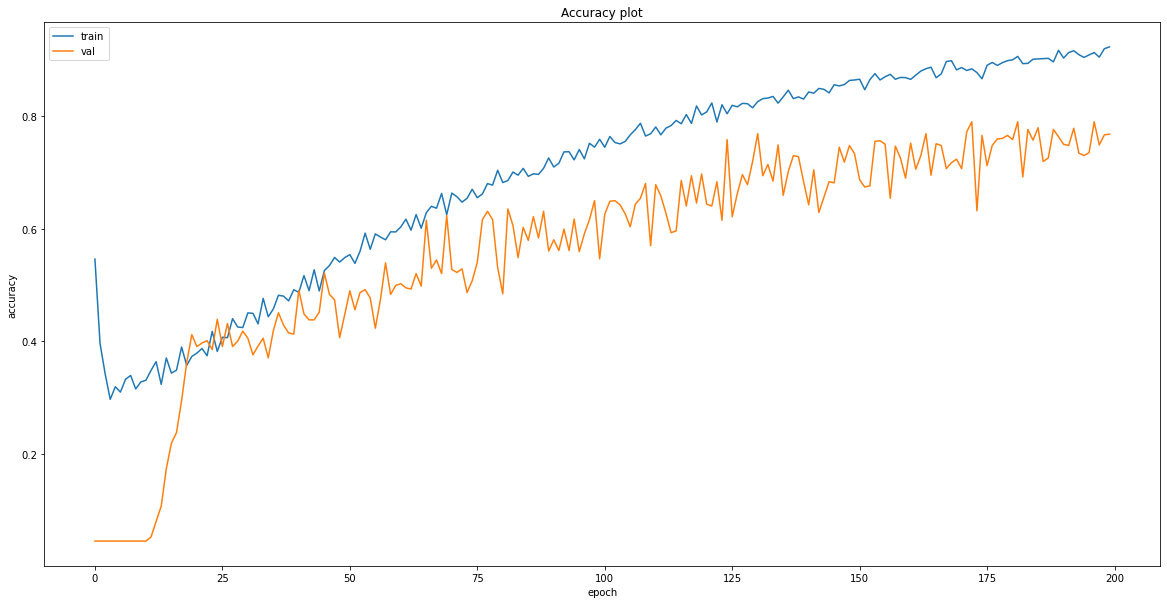

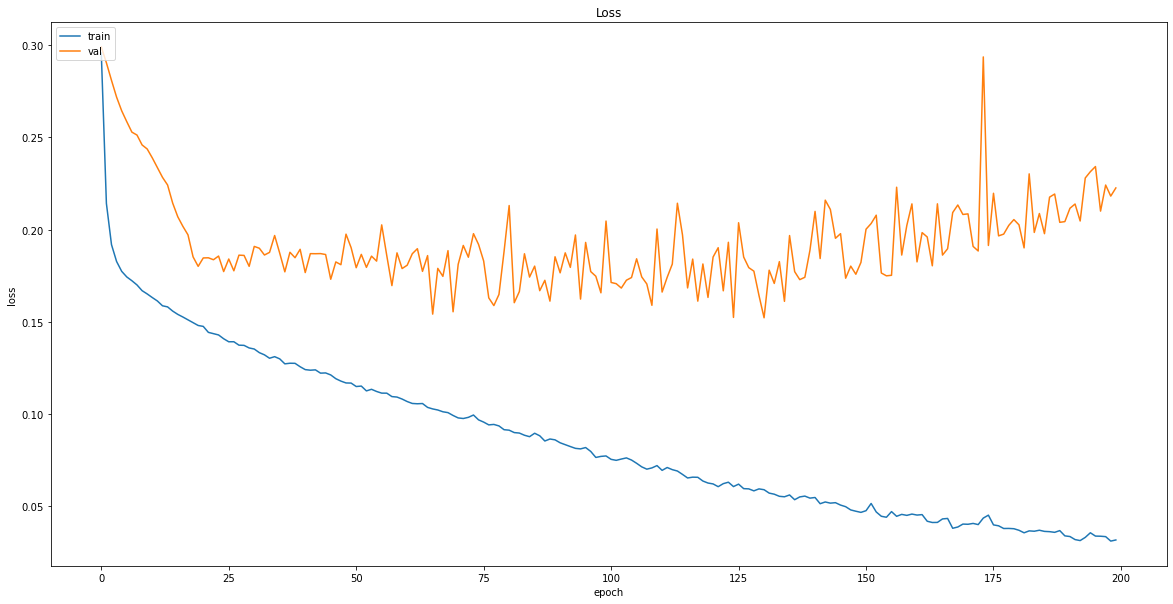

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('HA_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/HA_time_series_lstm_buy_hold_sell.model\assets


## JetBlue Airways Corporation  (Mid Cap)

In [23]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JBLU_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
1  2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2  2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
3  2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
4  2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


In [24]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


In [25]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [26]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4175, 15, 4)

In [27]:
y = labels
y = np.array(y)

In [28]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [29]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [30]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
27/27 [==============================] - 1s 32ms/step - loss: 0.2954 - accuracy: 0.5240 - mse: 0.4366 - weighted_accuracy: 0.3266 - weighted_mse: 0.5115 - val_loss: 0.3001 - val_accuracy: 0.0431 - val_mse: 0.3519 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 0.3519
Epoch 2/200
27/27 [==============================] - 0s 7ms/step - loss: 0.2146 - accuracy: 0.3713 - mse: 0.7316 - weighted_accuracy: 0.4457 - weighted_mse: 0.7193 - val_loss: 0.2934 - val_accuracy: 0.0443 - val_mse: 0.3776 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3776
Epoch 3/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1913 - accuracy: 0.3216 - mse: 0.9504 - weighted_accuracy: 0.4956 - weighted_mse: 0.9197 - val_loss: 0.2855 - val_accuracy: 0.0443 - val_mse: 0.4121 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.4121
Epoch 4/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1816 - accuracy: 0.2796 - mse: 1.1029 - weighted_accuracy: 0.5290 - weighte

Epoch 30/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1339 - accuracy: 0.3805 - mse: 1.7190 - weighted_accuracy: 0.7010 - weighted_mse: 1.6301 - val_loss: 0.1910 - val_accuracy: 0.3473 - val_mse: 1.6660 - val_weighted_accuracy: 0.3473 - val_weighted_mse: 1.6660
Epoch 31/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1331 - accuracy: 0.4117 - mse: 1.6896 - weighted_accuracy: 0.7320 - weighted_mse: 1.6014 - val_loss: 0.1891 - val_accuracy: 0.3725 - val_mse: 1.7192 - val_weighted_accuracy: 0.3725 - val_weighted_mse: 1.7192
Epoch 32/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1317 - accuracy: 0.4251 - mse: 1.7367 - weighted_accuracy: 0.7238 - weighted_mse: 1.6713 - val_loss: 0.1869 - val_accuracy: 0.4144 - val_mse: 1.5930 - val_weighted_accuracy: 0.4144 - val_weighted_mse: 1.5930
Epoch 33/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1328 - accuracy: 0.3751 - mse: 1.7729 - weighted_accuracy: 0.7224 - weig

Epoch 59/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1144 - accuracy: 0.5728 - mse: 2.0547 - weighted_accuracy: 0.7994 - weighted_mse: 2.0557 - val_loss: 0.1992 - val_accuracy: 0.4299 - val_mse: 2.2488 - val_weighted_accuracy: 0.4299 - val_weighted_mse: 2.2488
Epoch 60/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1128 - accuracy: 0.5572 - mse: 2.1464 - weighted_accuracy: 0.8083 - weighted_mse: 2.1342 - val_loss: 0.1795 - val_accuracy: 0.5006 - val_mse: 2.0526 - val_weighted_accuracy: 0.5006 - val_weighted_mse: 2.0526
Epoch 61/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1161 - accuracy: 0.5015 - mse: 2.0959 - weighted_accuracy: 0.7733 - weighted_mse: 2.0814 - val_loss: 0.2086 - val_accuracy: 0.4240 - val_mse: 2.1899 - val_weighted_accuracy: 0.4240 - val_weighted_mse: 2.1899
Epoch 62/200
27/27 [==============================] - 0s 6ms/step - loss: 0.1126 - accuracy: 0.5308 - mse: 2.1465 - weighted_accuracy: 0.7901 - weig

27/27 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 0.6168 - mse: 2.5664 - weighted_accuracy: 0.8403 - weighted_mse: 2.6037 - val_loss: 0.1824 - val_accuracy: 0.5365 - val_mse: 2.7409 - val_weighted_accuracy: 0.5365 - val_weighted_mse: 2.7409
Epoch 88/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0951 - accuracy: 0.6614 - mse: 2.5782 - weighted_accuracy: 0.8569 - weighted_mse: 2.6335 - val_loss: 0.1650 - val_accuracy: 0.6036 - val_mse: 2.7566 - val_weighted_accuracy: 0.6036 - val_weighted_mse: 2.7566
Epoch 89/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0962 - accuracy: 0.6551 - mse: 2.6451 - weighted_accuracy: 0.8570 - weighted_mse: 2.6818 - val_loss: 0.1943 - val_accuracy: 0.4958 - val_mse: 2.6799 - val_weighted_accuracy: 0.4958 - val_weighted_mse: 2.6799
Epoch 90/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0975 - accuracy: 0.6659 - mse: 2.6015 - weighted_accuracy: 0.8457 - weighted_mse: 2.6

Epoch 116/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.7099 - mse: 3.1847 - weighted_accuracy: 0.8895 - weighted_mse: 3.2858 - val_loss: 0.1727 - val_accuracy: 0.6204 - val_mse: 3.4708 - val_weighted_accuracy: 0.6204 - val_weighted_mse: 3.4708
Epoch 117/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0784 - accuracy: 0.7515 - mse: 3.2131 - weighted_accuracy: 0.8985 - weighted_mse: 3.3642 - val_loss: 0.1839 - val_accuracy: 0.5856 - val_mse: 3.2609 - val_weighted_accuracy: 0.5856 - val_weighted_mse: 3.2609
Epoch 118/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0811 - accuracy: 0.7123 - mse: 3.2677 - weighted_accuracy: 0.8905 - weighted_mse: 3.3773 - val_loss: 0.1866 - val_accuracy: 0.5904 - val_mse: 3.1532 - val_weighted_accuracy: 0.5904 - val_weighted_mse: 3.1532
Epoch 119/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0792 - accuracy: 0.7461 - mse: 3.2951 - weighted_accuracy: 0.8924 - 

Epoch 145/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.7919 - mse: 3.8520 - weighted_accuracy: 0.8986 - weighted_mse: 3.9890 - val_loss: 0.1808 - val_accuracy: 0.6479 - val_mse: 4.1502 - val_weighted_accuracy: 0.6479 - val_weighted_mse: 4.1502
Epoch 146/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0661 - accuracy: 0.7766 - mse: 4.0022 - weighted_accuracy: 0.9076 - weighted_mse: 4.1379 - val_loss: 0.1681 - val_accuracy: 0.6982 - val_mse: 4.1262 - val_weighted_accuracy: 0.6982 - val_weighted_mse: 4.1262
Epoch 147/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0659 - accuracy: 0.7862 - mse: 3.9845 - weighted_accuracy: 0.9049 - weighted_mse: 4.0962 - val_loss: 0.1752 - val_accuracy: 0.6563 - val_mse: 4.0682 - val_weighted_accuracy: 0.6563 - val_weighted_mse: 4.0682
Epoch 148/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0692 - accuracy: 0.7689 - mse: 3.9996 - weighted_accuracy: 0.9046 - 

Epoch 174/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0656 - accuracy: 0.7916 - mse: 4.7381 - weighted_accuracy: 0.9066 - weighted_mse: 4.9329 - val_loss: 0.1802 - val_accuracy: 0.6910 - val_mse: 4.9738 - val_weighted_accuracy: 0.6910 - val_weighted_mse: 4.9738
Epoch 175/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.8135 - mse: 4.7374 - weighted_accuracy: 0.9253 - weighted_mse: 4.9205 - val_loss: 0.1708 - val_accuracy: 0.7150 - val_mse: 5.0297 - val_weighted_accuracy: 0.7150 - val_weighted_mse: 5.0297
Epoch 176/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.7937 - mse: 4.6610 - weighted_accuracy: 0.9097 - weighted_mse: 4.7715 - val_loss: 0.1908 - val_accuracy: 0.6611 - val_mse: 5.0574 - val_weighted_accuracy: 0.6611 - val_weighted_mse: 5.0574
Epoch 177/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.8024 - mse: 4.8794 - weighted_accuracy: 0.9211 - 

In [33]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16950085759162903
Test accuracy: 0.7269461154937744


In [34]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.2527716  -3.4250607   1.7728004 ]
 [-2.7219472  -2.2219741   1.1475317 ]
 [-2.933526   -0.811966   -0.15533964]
 ...
 [-1.5008894  -2.5341852   0.8140357 ]
 [-2.2209995  -3.815407    1.3914002 ]
 [-1.0377162  -5.261999   -0.1679668 ]]


Counter({2: 663, 1: 90, 0: 82})

In [35]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 760, 1: 37, 0: 38})

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 835
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 32
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 33
actual holds but predicted buy: 84
actual holds but predicted sell: 78
actual predicted holds: 598
Percentage buys correct: 13.513513513513514%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 78.6842105263158%
actual buys: 37
actual sells: 38
actual holds: 760


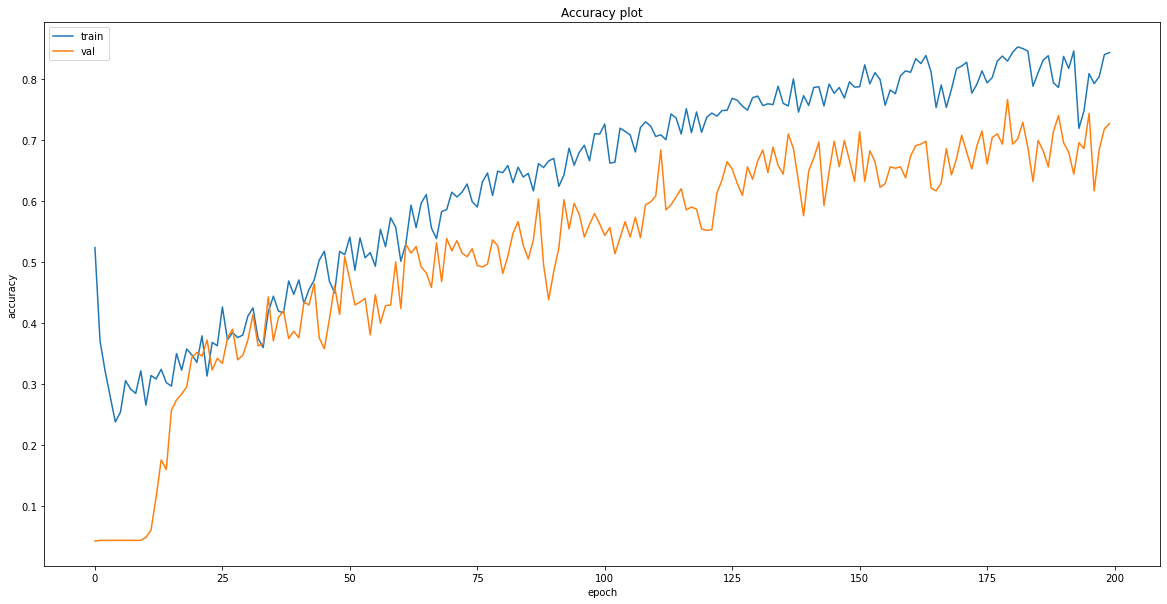

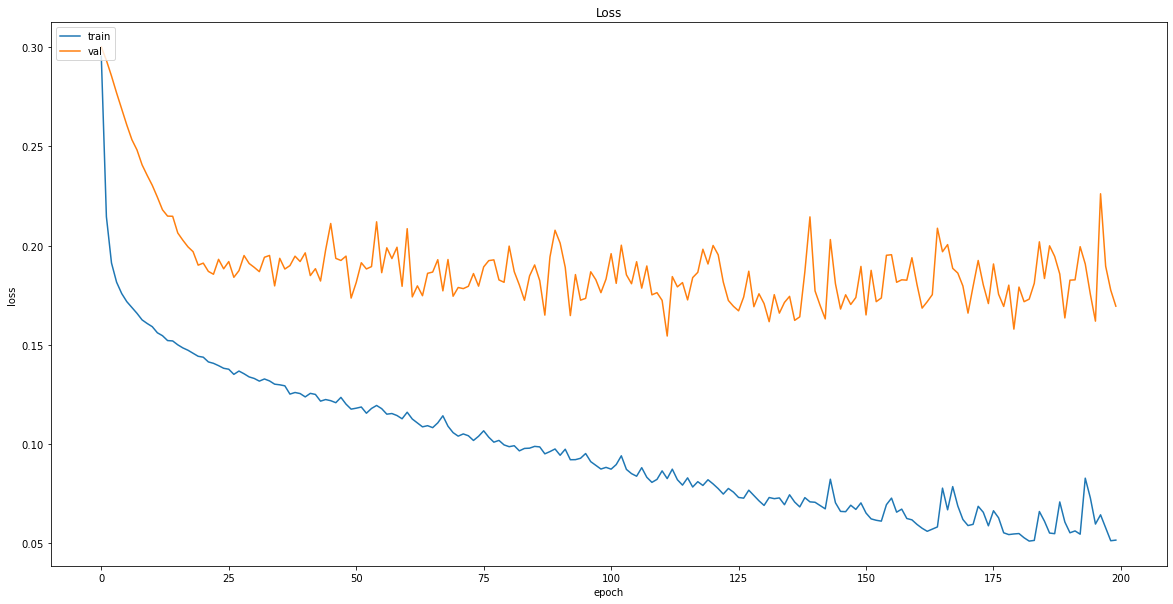

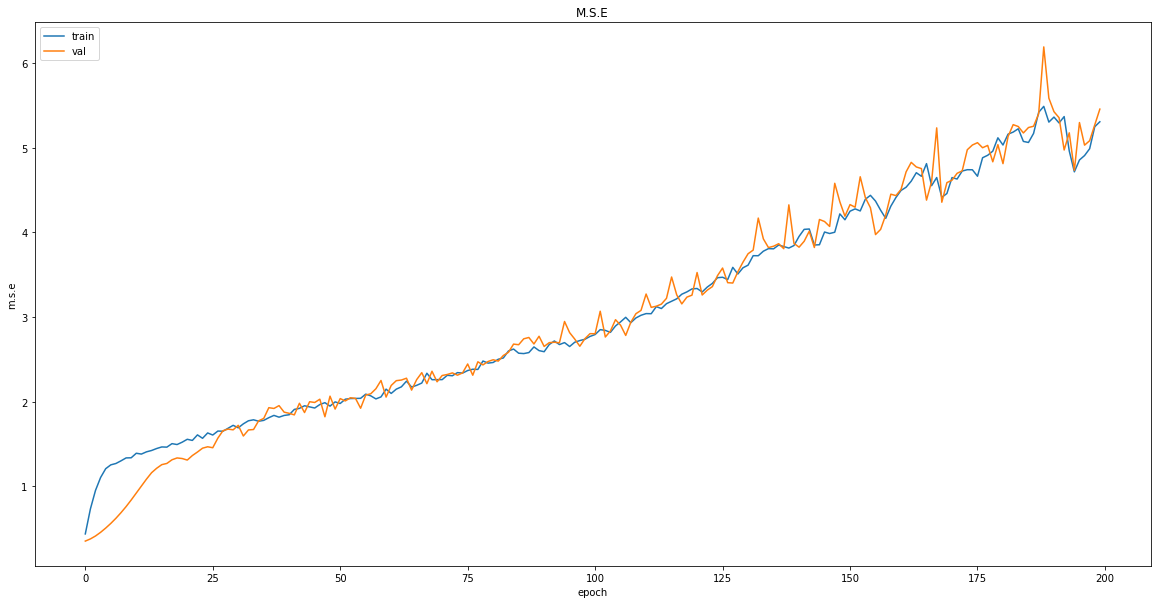

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
# Save model
model.save("models/{}".format('JBLU_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JBLU_time_series_lstm_buy_hold_sell.model\assets


## American Airlines Group Inc. (Large Cap)

In [39]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AAL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2005-10-17    22.270000  21.619546 -18.717939  12563700.0     2.0
1  2005-10-18    22.080000  21.690385 -24.210533  12099700.0     2.0
2  2005-10-19    21.490000  21.659557 -52.068980  10284200.0     2.0
3  2005-10-20    21.379999  21.616548 -57.446844   8818200.0     1.0
4  2005-10-21    21.020000  21.524771 -92.093018   8177300.0     2.0


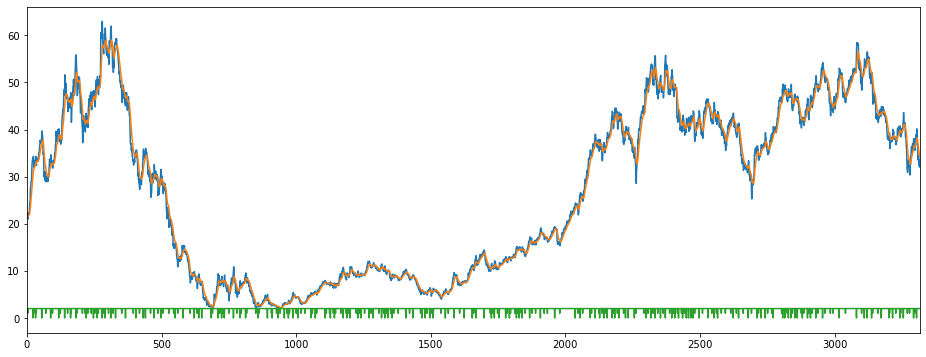

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [41]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2005-10-17,22.270000,21.619546,-18.717939,12563700.0,2.0
2005-10-18,22.080000,21.690385,-24.210533,12099700.0,2.0
2005-10-19,21.490000,21.659557,-52.068980,10284200.0,2.0
2005-10-20,21.379999,21.616548,-57.446844,8818200.0,1.0
2005-10-21,21.020000,21.524771,-92.093018,8177300.0,2.0


In [42]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [43]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(3303, 15, 4)

In [44]:
y = labels
y = np.array(y)

In [45]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [46]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [47]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [49]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
21/21 [==============================] - 1s 39ms/step - loss: 0.3169 - accuracy: 0.5193 - mse: 0.4126 - weighted_accuracy: 0.2935 - weighted_mse: 0.5046 - val_loss: 0.3013 - val_accuracy: 0.0469 - val_mse: 0.3479 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.3479
Epoch 2/200
21/21 [==============================] - 0s 8ms/step - loss: 0.2304 - accuracy: 0.4489 - mse: 0.6233 - weighted_accuracy: 0.4093 - weighted_mse: 0.6242 - val_loss: 0.2962 - val_accuracy: 0.0424 - val_mse: 0.3653 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.3653
Epoch 3/200
21/21 [==============================] - 0s 8ms/step - loss: 0.2009 - accuracy: 0.3414 - mse: 0.8478 - weighted_accuracy: 0.4549 - weighted_mse: 0.8118 - val_loss: 0.2895 - val_accuracy: 0.0424 - val_mse: 0.3907 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.3907
Epoch 4/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1879 - accuracy: 0.3164 - mse: 1.0188 - weighted_accuracy: 0.5052 - weighte

Epoch 30/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1315 - accuracy: 0.4345 - mse: 1.6193 - weighted_accuracy: 0.7261 - weighted_mse: 1.4967 - val_loss: 0.1826 - val_accuracy: 0.3873 - val_mse: 1.5013 - val_weighted_accuracy: 0.3873 - val_weighted_mse: 1.5013
Epoch 31/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1306 - accuracy: 0.4807 - mse: 1.6364 - weighted_accuracy: 0.7374 - weighted_mse: 1.5386 - val_loss: 0.1891 - val_accuracy: 0.3480 - val_mse: 1.5470 - val_weighted_accuracy: 0.3480 - val_weighted_mse: 1.5470
Epoch 32/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.4391 - mse: 1.6702 - weighted_accuracy: 0.7363 - weighted_mse: 1.5465 - val_loss: 0.1831 - val_accuracy: 0.3828 - val_mse: 1.5871 - val_weighted_accuracy: 0.3828 - val_weighted_mse: 1.5871
Epoch 33/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.4671 - mse: 1.6746 - weighted_accuracy: 0.7408 - weig

Epoch 59/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.6075 - mse: 2.1660 - weighted_accuracy: 0.8344 - weighted_mse: 2.0950 - val_loss: 0.1681 - val_accuracy: 0.5688 - val_mse: 2.2158 - val_weighted_accuracy: 0.5688 - val_weighted_mse: 2.2158
Epoch 60/200
21/21 [==============================] - 0s 6ms/step - loss: 0.1038 - accuracy: 0.6075 - mse: 2.1795 - weighted_accuracy: 0.8288 - weighted_mse: 2.1106 - val_loss: 0.1707 - val_accuracy: 0.5537 - val_mse: 2.1524 - val_weighted_accuracy: 0.5537 - val_weighted_mse: 2.1524
Epoch 61/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.6071 - mse: 2.2013 - weighted_accuracy: 0.8257 - weighted_mse: 2.1382 - val_loss: 0.1714 - val_accuracy: 0.5386 - val_mse: 2.2488 - val_weighted_accuracy: 0.5386 - val_weighted_mse: 2.2488
Epoch 62/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1019 - accuracy: 0.6294 - mse: 2.2000 - weighted_accuracy: 0.8282 - weig

Epoch 88/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.7256 - mse: 2.8740 - weighted_accuracy: 0.8830 - weighted_mse: 2.8608 - val_loss: 0.1501 - val_accuracy: 0.6808 - val_mse: 2.7643 - val_weighted_accuracy: 0.6808 - val_weighted_mse: 2.7643
Epoch 89/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0817 - accuracy: 0.7157 - mse: 2.9120 - weighted_accuracy: 0.8823 - weighted_mse: 2.8825 - val_loss: 0.1596 - val_accuracy: 0.6430 - val_mse: 3.1205 - val_weighted_accuracy: 0.6430 - val_weighted_mse: 3.1205
Epoch 90/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0803 - accuracy: 0.7453 - mse: 2.9295 - weighted_accuracy: 0.8930 - weighted_mse: 2.9391 - val_loss: 0.1719 - val_accuracy: 0.6112 - val_mse: 2.9668 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 2.9668
Epoch 91/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0766 - accuracy: 0.7301 - mse: 2.9489 - weighted_accuracy: 0.8960 - weig

Epoch 117/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0592 - accuracy: 0.8191 - mse: 3.9856 - weighted_accuracy: 0.9312 - weighted_mse: 3.9781 - val_loss: 0.1744 - val_accuracy: 0.6596 - val_mse: 4.1798 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 4.1798
Epoch 118/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0592 - accuracy: 0.8176 - mse: 4.0567 - weighted_accuracy: 0.9250 - weighted_mse: 4.0768 - val_loss: 0.1643 - val_accuracy: 0.6808 - val_mse: 4.0692 - val_weighted_accuracy: 0.6808 - val_weighted_mse: 4.0692
Epoch 119/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0609 - accuracy: 0.8221 - mse: 4.0868 - weighted_accuracy: 0.9267 - weighted_mse: 4.0885 - val_loss: 0.2000 - val_accuracy: 0.5991 - val_mse: 3.9897 - val_weighted_accuracy: 0.5991 - val_weighted_mse: 3.9897
Epoch 120/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.8278 - mse: 4.1272 - weighted_accuracy: 0.9316 - 

Epoch 146/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.8793 - mse: 5.6092 - weighted_accuracy: 0.9475 - weighted_mse: 5.4262 - val_loss: 0.1798 - val_accuracy: 0.7201 - val_mse: 5.7270 - val_weighted_accuracy: 0.7201 - val_weighted_mse: 5.7270
Epoch 147/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.8740 - mse: 5.4736 - weighted_accuracy: 0.9513 - weighted_mse: 5.3346 - val_loss: 0.1757 - val_accuracy: 0.7126 - val_mse: 5.4838 - val_weighted_accuracy: 0.7126 - val_weighted_mse: 5.4838
Epoch 148/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0430 - accuracy: 0.8864 - mse: 5.6478 - weighted_accuracy: 0.9558 - weighted_mse: 5.3832 - val_loss: 0.1738 - val_accuracy: 0.7458 - val_mse: 5.8793 - val_weighted_accuracy: 0.7458 - val_weighted_mse: 5.8793
Epoch 149/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.8849 - mse: 5.7548 - weighted_accuracy: 0.9552 - 

Epoch 175/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9141 - mse: 7.5047 - weighted_accuracy: 0.9687 - weighted_mse: 6.9984 - val_loss: 0.2194 - val_accuracy: 0.7020 - val_mse: 7.4137 - val_weighted_accuracy: 0.7020 - val_weighted_mse: 7.4137
Epoch 176/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9095 - mse: 7.4516 - weighted_accuracy: 0.9670 - weighted_mse: 6.9425 - val_loss: 0.2120 - val_accuracy: 0.7247 - val_mse: 7.3743 - val_weighted_accuracy: 0.7247 - val_weighted_mse: 7.3743
Epoch 177/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 0.9175 - mse: 7.5947 - weighted_accuracy: 0.9671 - weighted_mse: 6.9719 - val_loss: 0.2142 - val_accuracy: 0.7186 - val_mse: 7.6557 - val_weighted_accuracy: 0.7186 - val_weighted_mse: 7.6557
Epoch 178/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0372 - accuracy: 0.8963 - mse: 7.5066 - weighted_accuracy: 0.9566 - 

In [50]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21984215080738068
Test accuracy: 0.7836611270904541


In [51]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.6419454  -1.9144415   1.9986268 ]
 [-2.3252501  -7.050308    2.3465095 ]
 [-3.9402072  -3.4919178   2.8464026 ]
 ...
 [-0.1084834  -3.7215593  -0.21575783]
 [-4.6801558   0.16992134 -0.9169238 ]
 [-4.6914635  -1.9790804   1.4025784 ]]


Counter({2: 564, 0: 57, 1: 40})

In [52]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 605, 1: 28, 0: 28})

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 661
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 27
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 23
actual holds but predicted buy: 37
actual holds but predicted sell: 54
actual predicted holds: 514
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 84.95867768595042%
actual buys: 28
actual sells: 28
actual holds: 605


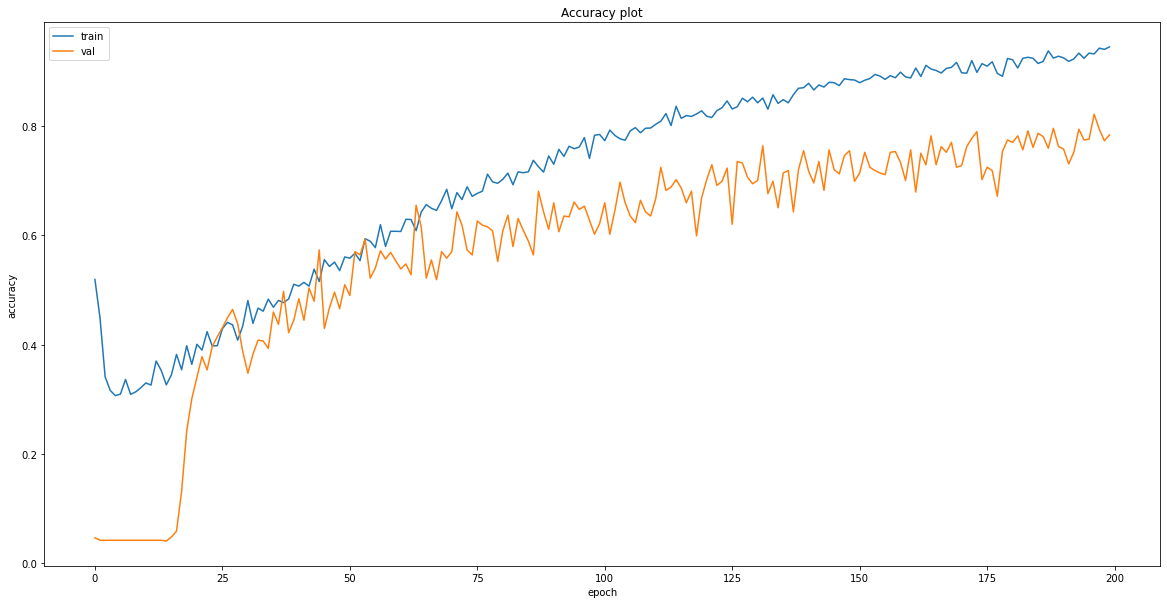

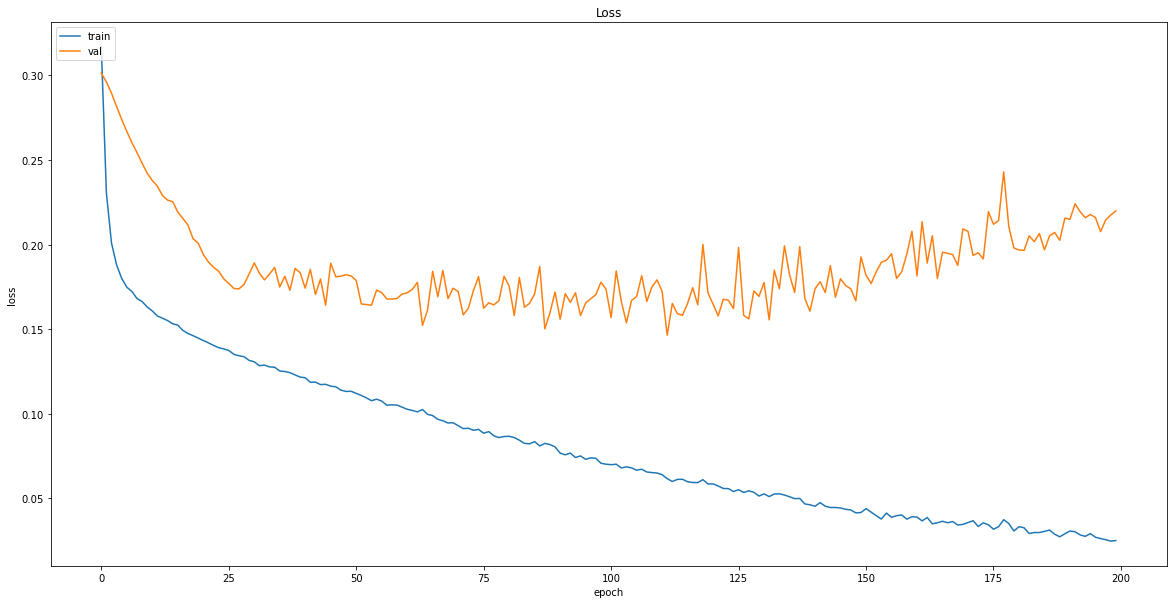

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
# Save model
model.save("models/{}".format('AAL_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/AAL_time_series_lstm_buy_hold_sell.model\assets
